In [1]:
#!pip install xgboost
#!pip install catboost

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import nltk

# Ensure nltk stopwords are downloaded
#nltk.download('stopwords')

# Custom stop words
custom_stopwords = nltk.corpus.stopwords.words('english')
stopword_list = ['moderna', 'flu', 'mrna', 'vaccine', 'the', 'patient', 'pfizer',
                 'biontech', 'nan', 'none', 'mg', 'medical', 'history', 'allergy',
                 'year', 'old', 'uk', 'nkda', 'nka', 'known', 'reported', 'listed']


In [5]:
# Load the dataset
ppv_clean = pd.read_csv(r'C:/Users/chand/Downloads/606/ppv_ML.csv')

# Preprocess the data
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,
                                 token_pattern=r"(?u)\b\w+\b",
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2), max_features=5000))])

tfidfprocess = ColumnTransformer(transformers=[
    ('text1', textTransformer_0, 'SYMPTOM_TEXT'),
    ('text2', textTransformer_0, 'OTHER_MEDS'),
    ('text3', textTransformer_0, 'CUR_ILL'),
    ('text4', textTransformer_0, 'HISTORY'),
    ('text5', textTransformer_0, 'ALLERGIES')],
    remainder='passthrough')

vaccine_data = pd.get_dummies(ppv_clean.VAX_MANU)
ppv_clean = pd.merge(ppv_clean, vaccine_data, left_index=True, right_index=True)
ppv_clean.rename(columns={'MERCK & CO. INC.': 'MERCK', 'PFIZER\\WYETH': 'WYETH', 'MSP VACCINE COMPANY':'MSP'}, inplace=True)

# Replace NaN values in specific columns with empty strings
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    ppv_clean[col] = ppv_clean[col].replace(np.nan, '', regex=True)

# Define the target and features
y = ppv_clean.SERIOUS
X = ppv_clean.drop(['SERIOUS', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
                    'SYMPTOM5', 'VAX_MANU'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=200, stratify=y)

# Print the size of the training and test sets
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=200, solver='liblinear', max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(learning_rate=0.1, depth=6, iterations=1000, random_state=42, verbose=0)
}

# Dictionary to store metrics for each model
model_results = {}

# Train each model and evaluate performance
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', tfidfprocess),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Collect performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract metrics for both classes (0 and 1)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    model_results[name] = {
        'Accuracy': accuracy,
        'Precision_0': precision_0,
        'Recall_0': recall_0,
        'F1-Score_0': f1_0,
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1-Score_1': f1_1
    }

# Display the results for all models side by side
print("\nPerformance Metrics for Each Model:")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision_0':<12} {'Precision_1':<12} {'Recall_0':<10} {'Recall_1':<10} {'F1-Score_0':<12} {'F1-Score_1':<12}")
for model_name, metrics in model_results.items():
    print(f"{model_name:<20} {metrics['Accuracy']:<10.4f} {metrics['Precision_0']:<12.4f} {metrics['Precision_1']:<12.4f} {metrics['Recall_0']:<10.4f} {metrics['Recall_1']:<10.4f} {metrics['F1-Score_0']:<12.4f} {metrics['F1-Score_1']:<12.4f}")


Training examples: 10,119
Test examples: 4,337

Performance Metrics for Each Model:
Model                Accuracy   Precision_0  Precision_1  Recall_0   Recall_1   F1-Score_0   F1-Score_1  
Logistic Regression  0.9760     0.9742       1.0000       1.0000     0.7488     0.9869       0.8564      
Random Forest        0.9705     0.9747       0.9206       0.9931     0.7560     0.9838       0.8302      
AdaBoost             0.9716     0.9696       1.0000       1.0000     0.7029     0.9846       0.8255      
XGBoost              0.9744     0.9755       0.9605       0.9967     0.7633     0.9860       0.8506      
CatBoost             0.9712     0.9776       0.9003       0.9908     0.7850     0.9842       0.8387      


In [2]:
# Load the dataset
varzos_clean = pd.read_csv(r'C:/Users/chand/Downloads/606/varzos_ML.csv')

# Preprocess the data
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,
                                 token_pattern=r"(?u)\b\w+\b",
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2), max_features=5000))])

tfidfprocess = ColumnTransformer(transformers=[
    ('text1', textTransformer_0, 'SYMPTOM_TEXT'),
    ('text2', textTransformer_0, 'OTHER_MEDS'),
    ('text3', textTransformer_0, 'CUR_ILL'),
    ('text4', textTransformer_0, 'HISTORY'),
    ('text5', textTransformer_0, 'ALLERGIES')],
    remainder='passthrough')

vaccine_data = pd.get_dummies(varzos_clean.VAX_MANU)
varzos_clean = pd.merge(varzos_clean, vaccine_data, left_index=True, right_index=True)
varzos_clean.rename(columns = {'GLAXOSMITHKLINE BIOLOGICALS':'GLAXOSMITHKLINE','MERCK & CO. INC.': 'MERCK'}, inplace = True)

# Replace NaN values in specific columns with empty strings
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    varzos_clean[col] = varzos_clean[col].replace(np.nan, '', regex=True)

# Define the target and features
y = varzos_clean.SERIOUS
X = varzos_clean.drop(['SERIOUS', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
                    'SYMPTOM5', 'VAX_MANU'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=200, stratify=y)

# Print the size of the training and test sets
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=200, solver='liblinear', max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(learning_rate=0.1, depth=6, iterations=1000, random_state=42, verbose=0)
}

# Dictionary to store metrics for each model
model_results = {}

# Train each model and evaluate performance
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', tfidfprocess),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Collect performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract metrics for both classes (0 and 1)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    model_results[name] = {
        'Accuracy': accuracy,
        'Precision_0': precision_0,
        'Recall_0': recall_0,
        'F1-Score_0': f1_0,
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1-Score_1': f1_1
    }

# Display the results for all models side by side
print("\nPerformance Metrics for Each Model(VARZOS):")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision_0':<12} {'Precision_1':<12} {'Recall_0':<10} {'Recall_1':<10} {'F1-Score_0':<12} {'F1-Score_1':<12}")
for model_name, metrics in model_results.items():
    print(f"{model_name:<20} {metrics['Accuracy']:<10.4f} {metrics['Precision_0']:<12.4f} {metrics['Precision_1']:<12.4f} {metrics['Recall_0']:<10.4f} {metrics['Recall_1']:<10.4f} {metrics['F1-Score_0']:<12.4f} {metrics['F1-Score_1']:<12.4f}")


Training examples: 40,589
Test examples: 17,396

Performance Metrics for Each Model(VARZOS):
Model                Accuracy   Precision_0  Precision_1  Recall_0   Recall_1   F1-Score_0   F1-Score_1  
Logistic Regression  0.9668     0.9670       0.9639       0.9976     0.6529     0.9821       0.7785      
Random Forest        0.9601     0.9706       0.8301       0.9861     0.6954     0.9783       0.7568      
AdaBoost             0.9626     0.9606       1.0000       1.0000     0.5815     0.9799       0.7353      
XGBoost              0.9669     0.9714       0.9075       0.9930     0.7012     0.9821       0.7911      
CatBoost             0.9669     0.9711       0.9095       0.9932     0.6986     0.9820       0.7902      


In [4]:
# Load the dataset
flu_clean = pd.read_csv(r'C:/Users/chand/Downloads/606/flu_ML.csv')

# Preprocess the data
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,
                                 token_pattern=r"(?u)\b\w+\b",
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2), max_features=5000))])

tfidfprocess = ColumnTransformer(transformers=[
    ('text1', textTransformer_0, 'SYMPTOM_TEXT'),
    ('text2', textTransformer_0, 'OTHER_MEDS'),
    ('text3', textTransformer_0, 'CUR_ILL'),
    ('text4', textTransformer_0, 'HISTORY'),
    ('text5', textTransformer_0, 'ALLERGIES')],
    remainder='passthrough')

vaccine_data = pd.get_dummies(flu_clean.VAX_MANU)
flu_clean = pd.merge(flu_clean, vaccine_data, left_index=True, right_index=True)
flu_clean.rename(columns = {'CSL LIMITED':'CSL','GLAXOSMITHKLINE BIOLOGICALS': 'GLAXOSMITHKLINE', 'NOVARTIS VACCINES AND DIAGNOSTICS':'NOVARTIS', 'PROTEIN SCIENCES CORPORATION': 'PROTEIN_SCIENCES', 'SANOFI PASTEUR':'SANOFI', 'SEQIRUS, INC.':'SEQIRUS','MEDIMMUNE VACCINES, INC.':'MEDIMMUNE'}, inplace = True)

# Replace NaN values in specific columns with empty strings
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    flu_clean[col] = flu_clean[col].replace(np.nan, '', regex=True)

# Define the target and features
y = flu_clean.SERIOUS
X = flu_clean.drop(['SERIOUS', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
                    'SYMPTOM5', 'VAX_MANU'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=200, stratify=y)

# Print the size of the training and test sets
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=200, solver='liblinear', max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(learning_rate=0.1, depth=6, iterations=1000, random_state=42, verbose=0)
}

# Dictionary to store metrics for each model
model_results = {}

# Train each model and evaluate performance
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', tfidfprocess),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Collect performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract metrics for both classes (0 and 1)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    model_results[name] = {
        'Accuracy': accuracy,
        'Precision_0': precision_0,
        'Recall_0': recall_0,
        'F1-Score_0': f1_0,
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1-Score_1': f1_1
    }

# Display the results for all models side by side
print("\nPerformance Metrics for Each Model (FLU):")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision_0':<12} {'Precision_1':<12} {'Recall_0':<10} {'Recall_1':<10} {'F1-Score_0':<12} {'F1-Score_1':<12}")
for model_name, metrics in model_results.items():
    print(f"{model_name:<20} {metrics['Accuracy']:<10.4f} {metrics['Precision_0']:<12.4f} {metrics['Precision_1']:<12.4f} {metrics['Recall_0']:<10.4f} {metrics['Recall_1']:<10.4f} {metrics['F1-Score_0']:<12.4f} {metrics['F1-Score_1']:<12.4f}")


Training examples: 40,375
Test examples: 17,304

Performance Metrics for Each Model (FLU):
Model                Accuracy   Precision_0  Precision_1  Recall_0   Recall_1   F1-Score_0   F1-Score_1  
Logistic Regression  0.9446     0.9450       0.9423       0.9898     0.7430     0.9669       0.8309      
Random Forest        0.9367     0.9458       0.8865       0.9785     0.7499     0.9619       0.8125      
AdaBoost             0.9179     0.9089       0.9977       0.9997     0.5526     0.9521       0.7112      
XGBoost              0.9454     0.9465       0.9392       0.9891     0.7506     0.9673       0.8343      
CatBoost             0.9443     0.9460       0.9345       0.9883     0.7483     0.9667       0.8311      


In [9]:
# Load the dataset
covid_clean = pd.read_csv(r'C:/Users/chand/Downloads/606/covid_ML.csv')

# Preprocess the data
textTransformer_0 = Pipeline(steps=[
    ('text_bow', TfidfVectorizer(lowercase=True,
                                 token_pattern=r"(?u)\b\w+\b",
                                 stop_words=stopword_list,
                                 ngram_range=(2, 2), max_features=5000))])

tfidfprocess = ColumnTransformer(transformers=[
    ('text1', textTransformer_0, 'SYMPTOM_TEXT'),
    ('text2', textTransformer_0, 'OTHER_MEDS'),
    ('text3', textTransformer_0, 'CUR_ILL'),
    ('text4', textTransformer_0, 'HISTORY'),
    ('text5', textTransformer_0, 'ALLERGIES')],
    remainder='passthrough')

vaccine_data = pd.get_dummies(covid_clean.VAX_MANU)
covid_clean = pd.merge(covid_clean, vaccine_data, left_index=True, right_index=True)
covid_clean.rename(columns = {'JANSSEN':'JANSSEN','MODERNA': 'MODERNA', 'NOVAVAX':'NOVAVAX', 'PFIZER\\BIONTECH': 'PFIZER'}, inplace = True)

# Replace NaN values in specific columns with empty strings
for col in ['OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'ALLERGIES']:
    covid_clean[col] = covid_clean[col].replace(np.nan, '', regex=True)

# Define the target and features
y = covid_clean.SERIOUS
X = covid_clean.drop(['SERIOUS', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
                    'SYMPTOM5', 'VAX_MANU'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=200, stratify=y)

# Print the size of the training and test sets
print(f'Training examples: {X_train.shape[0]:,}')
print(f'Test examples: {X_test.shape[0]:,}')

print(X_train.columns)

Training examples: 620,627
Test examples: 265,983
Index(['AGE_YRS', 'SEX', 'SYMPTOM_TEXT', 'DIED', 'L_THREAT', 'HOSPITAL',
       'HOSPDAYS', 'DISABLE', 'RECOVD', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY',
       'BIRTH_DEFECT', 'ALLERGIES', 'JANSSEN', 'MODERNA', 'NOVAVAX', 'PFIZER'],
      dtype='object')


In [7]:
# Logistic Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', tfidfprocess),
    ('model', LogisticRegression(random_state=200, solver='liblinear', max_iter=1000))
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

# Collect metrics
accuracy_covid_lr = accuracy_score(y_test, y_pred_lr)
report_covid_lr = classification_report(y_test, y_pred_lr, output_dict=True)

print("Logistic Regression (COVID Dataset):")
print("Accuracy:", accuracy_covid_lr)
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression (COVID Dataset):
Accuracy: 0.9403646097682935
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96    203584
           1       0.95      0.78      0.86     62399

    accuracy                           0.94    265983
   macro avg       0.95      0.89      0.91    265983
weighted avg       0.94      0.94      0.94    265983



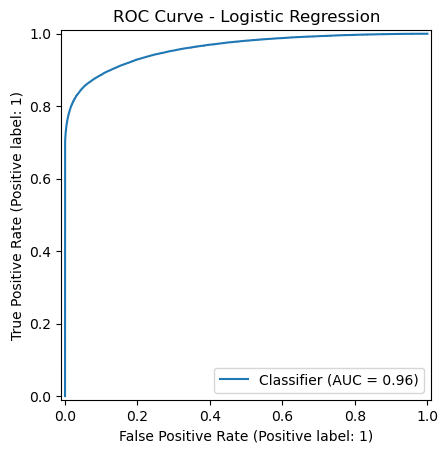

In [14]:
# Plot ROC Curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

y_proba_log = pipeline_lr.predict_proba(X_test)[:, 1] 
RocCurveDisplay.from_predictions(y_test, y_proba_log)
plt.title("ROC Curve - Logistic Regression")
plt.show()

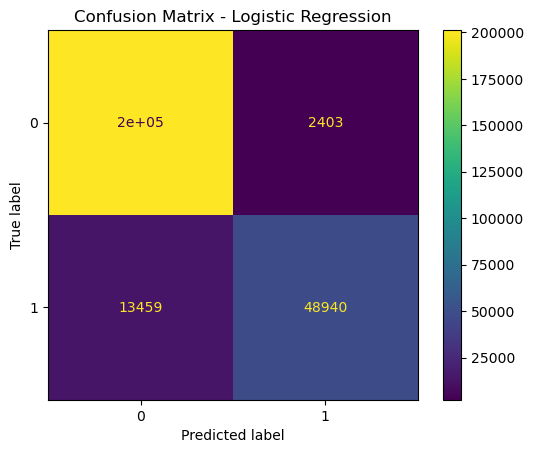

In [17]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [10]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=200, solver='saga', max_iter=500, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=30, max_depth=7, n_jobs=-1, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=30, algorithm='SAMME', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=30, max_depth=7, tree_method='hist', random_state=42),
    "CatBoost": CatBoostClassifier(learning_rate=0.1, depth=4, iterations=50, thread_count=-1,
                                    task_type="CPU", random_state=42, verbose=0)
}

# Dictionary to store metrics for each model
model_results = {}

# Train each model and evaluate performance
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', tfidfprocess),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Collect performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Extract metrics for both classes (0 and 1)
    precision_0 = report['0']['precision']
    recall_0 = report['0']['recall']
    f1_0 = report['0']['f1-score']
    
    precision_1 = report['1']['precision']
    recall_1 = report['1']['recall']
    f1_1 = report['1']['f1-score']

    model_results[name] = {
        'Accuracy': accuracy,
        'Precision_0': precision_0,
        'Recall_0': recall_0,
        'F1-Score_0': f1_0,
        'Precision_1': precision_1,
        'Recall_1': recall_1,
        'F1-Score_1': f1_1
    }

# Display the results for all models side by side
print("\nPerformance Metrics for Each Model (Covid):")
print(f"{'Model':<20} {'Accuracy':<10} {'Precision_0':<12} {'Precision_1':<12} {'Recall_0':<10} {'Recall_1':<10} {'F1-Score_0':<12} {'F1-Score_1':<12}")
for model_name, metrics in model_results.items():
    print(f"{model_name:<20} {metrics['Accuracy']:<10.4f} {metrics['Precision_0']:<12.4f} {metrics['Precision_1']:<12.4f} {metrics['Recall_0']:<10.4f} {metrics['Recall_1']:<10.4f} {metrics['F1-Score_0']:<12.4f} {metrics['F1-Score_1']:<12.4f}")


C:\Users\chand\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Performance Metrics for Each Model (Covid):
Model                Accuracy   Precision_0  Precision_1  Recall_0   Recall_1   F1-Score_0   F1-Score_1  
Logistic Regression  0.7671     0.7667       1.0000       1.0000     0.0071     0.8679       0.0141      
Random Forest        0.8018     0.7944       0.9939       0.9997     0.1560     0.8853       0.2697      
AdaBoost             0.9115     0.8964       1.0000       1.0000     0.6229     0.9454       0.7676      
XGBoost              0.9376     0.9296       0.9739       0.9938     0.7543     0.9606       0.8502      
CatBoost             0.9341     0.9239       0.9827       0.9960     0.7322     0.9586       0.8392      
